In [1]:
import pandas as pd
import numpy as np
import random
import torch
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from src.data_utils import (
    split_data,
    create_sequences,
    aggregate_daily)
import src.evaluation as evaluation
from src.train import train_nn_model, DEVICE
from src.models import MarketRegimeGRU, MarketRegimeCNN

In [2]:
df = pd.read_parquet('data/final_df.parquet')
df.head()

,Date,Ticker,Ret_1d,Ret_21d,RSI_14d,Sector_Dispersion,Trend_Dist,Rel_Volume,Bull_Bear_Regime,Target_Regime_5d
0,2000-01-03,GE,-0.031175,0.110280,52.427806,0.033400,0.264960,1.200274,Bear,1.0
1,2000-01-03,CAT,0.032661,0.023408,58.447502,0.033400,-0.128287,1.432774,Bear,1.0
2,2000-01-03,RTX,-0.039221,0.061344,59.314200,0.033400,-0.014154,0.857426,Bear,1.0
3,2000-01-03,BA,-0.030630,0.001557,62.307613,0.033400,-0.047088,0.708784,Bear,1.0
4,2000-01-03,BRK-B,-0.036165,-0.047035,47.023795,0.016239,-0.168843,0.820248,Bear,1.0


In [3]:
regime_ts = df[['Date', 'Target_Regime_5d']].drop_duplicates('Date').sort_values('Date')

transition_dates = regime_ts[regime_ts['Target_Regime_5d'].diff() == 1]['Date']

print(transition_dates.tolist())

[Timestamp('2000-10-06 00:00:00'), Timestamp('2000-11-13 00:00:00'), Timestamp('2000-11-28 00:00:00'), Timestamp('2001-03-05 00:00:00'), Timestamp('2001-09-04 00:00:00'), Timestamp('2002-05-07 00:00:00'), Timestamp('2002-05-24 00:00:00'), Timestamp('2002-05-30 00:00:00'), Timestamp('2002-06-27 00:00:00'), Timestamp('2002-09-18 00:00:00'), Timestamp('2003-03-10 00:00:00'), Timestamp('2003-03-17 00:00:00'), Timestamp('2007-03-14 00:00:00'), Timestamp('2007-07-20 00:00:00'), Timestamp('2007-10-25 00:00:00'), Timestamp('2008-04-30 00:00:00'), Timestamp('2008-05-30 00:00:00'), Timestamp('2009-06-09 00:00:00'), Timestamp('2009-07-08 00:00:00'), Timestamp('2010-05-03 00:00:00'), Timestamp('2010-06-22 00:00:00'), Timestamp('2011-08-01 00:00:00'), Timestamp('2011-09-14 00:00:00'), Timestamp('2011-10-18 00:00:00'), Timestamp('2011-10-20 00:00:00'), Timestamp('2011-11-02 00:00:00'), Timestamp('2011-11-22 00:00:00'), Timestamp('2014-10-14 00:00:00'), Timestamp('2014-12-31 00:00:00'), Timestamp('20

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(42)

In [5]:
feature_map = {
    'Ret_1d': 'Ret_1d',
    'Ret_21d': 'Ret_21d',
    'RSI_14d': 'RSI_14d',
    'Ret1d_Std_Dev': 'Sector_Dispersion',
    'Price_vs_MA200': 'Trend_Dist',
    'Rel_Volume': 'Rel_Volume',
}
feature_cols = list(feature_map.values())

SEQ_LENGTH = 21
INPUT_DIM = len(feature_cols)
gru_grid = {'hidden_dim': [64, 128],
            'lr': [0.001, 0.01],
            'dropout': [0.1, 0.2],
            'alpha': [0.5, 0.75],
            'gamma': [2.5, 4.0]
}
cnn_grid = {'filters': [32, 64],
            'kernel': [3, 4],
            'lr': [0.001, 0.01],
            'dropout': [0.1, 0.2],
            'alpha': [0.5, 0.75],
            'gamma': [2.5, 4.0]
}

(X_dev, y_dev), (X_test, y_test) = split_data(df, feature_cols)

In [6]:
full_df = X_dev.copy()
full_df['Target_Regime_5d'] = y_dev

X_all_seq, y_all_seq, indices_all = create_sequences(full_df, feature_cols, SEQ_LENGTH)
sequence_dates = X_dev.loc[indices_all, 'Date'].values
unique_dates = np.sort(X_dev['Date'].unique())

tscv = TimeSeriesSplit(n_splits=3)

for fold, (train_idx, val_idx) in enumerate(tscv.split(unique_dates)):
    train_dates_arr = unique_dates[train_idx]
    val_dates_arr = unique_dates[val_idx]
    
    train_mask = np.isin(sequence_dates, train_dates_arr)
    val_mask = np.isin(sequence_dates, val_dates_arr)
    
    X_train_seq = X_all_seq[train_mask]
    y_train_seq = y_all_seq[train_mask]
    tr_indices = indices_all[train_mask]
    
    X_val_seq = X_all_seq[val_mask]
    y_val_seq = y_all_seq[val_mask]
    va_indices = indices_all[val_mask]
    
    scaler = StandardScaler()
    N_tr, T, D = X_train_seq.shape
    X_train_reshaped = X_train_seq.reshape(-1, D)
    scaler.fit(X_train_reshaped)

    X_train_seq = scaler.transform(X_train_reshaped).reshape(N_tr, T, D)
    
    N_va = X_val_seq.shape[0]
    X_val_seq = scaler.transform(X_val_seq.reshape(-1, D)).reshape(N_va, T, D)
    
    print(f"Fold {fold} | Train Seq: {X_train_seq.shape} | Val Seq: {X_val_seq.shape}")

Fold 0 | Train Seq: (51797, 21, 6) | Val Seq: (57952, 21, 6)
Fold 1 | Train Seq: (109749, 21, 6) | Val Seq: (64381, 21, 6)
Fold 2 | Train Seq: (174130, 21, 6) | Val Seq: (66568, 21, 6)


In [7]:
models = [
    {
        'type': 'GRU',
        'class': MarketRegimeGRU,
        'grid': gru_grid
    },
    {
        'type': 'CNN',
        'class': MarketRegimeCNN,
        'grid': cnn_grid
    }
]

results = {}

for model in models:
    model_type = model['type']
    model_class = model['class']
    param_grid = model['grid']
    
    keys, values = zip(*param_grid.items())
    best_cv_auc = 0
    best_params = None

    for params_vals in product(*values):
        params = dict(zip(keys, params_vals))

        torch.manual_seed(42)

        fold_aucs = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(unique_dates)):

            train_dates, val_dates = unique_dates[train_idx], unique_dates[val_idx]
            X_f_train = X_dev[X_dev['Date'].isin(train_dates)].copy()
            y_f_train = y_dev[X_dev['Date'].isin(train_dates)].copy()
            X_f_val = X_dev[X_dev['Date'].isin(val_dates)].copy()
            y_f_val = y_dev[X_dev['Date'].isin(val_dates)].copy()

            scaler = StandardScaler()
            X_f_train[feature_cols] = scaler.fit_transform(X_f_train[feature_cols])
            X_f_val[feature_cols] = scaler.transform(X_f_val[feature_cols])

            train_df = X_f_train.copy(); train_df['Target_Regime_5d'] = y_f_train
            val_df = X_f_val.copy(); val_df['Target_Regime_5d'] = y_f_val

            X_tr_seq, y_tr_seq, train_indices = create_sequences(train_df, feature_cols, SEQ_LENGTH)
            X_va_seq, y_va_seq, val_indices = create_sequences(val_df, feature_cols, SEQ_LENGTH)

            if model_type == 'GRU':
                model = model_class(INPUT_DIM, params['hidden_dim'], 2, params['dropout']).to(DEVICE)
            else:
                model = model_class(INPUT_DIM, SEQ_LENGTH, params['dropout'], params['filters'], params['kernel']).to(DEVICE)

            model, fold_auc = train_nn_model(
                model, (X_tr_seq, y_tr_seq), (X_va_seq, y_va_seq),
                train_indices, val_indices, train_df, val_df, params['lr'],
                alpha=params['alpha'], gamma=params['gamma']
            )
            fold_aucs.append(fold_auc)

        mean_cv_auc = np.mean(fold_aucs)
        if mean_cv_auc > best_cv_auc:
            best_cv_auc, best_params = mean_cv_auc, params

    print(f"Result for {model_type}: Best AUC {best_cv_auc:.4f} with {best_params}")

    results[model_type] = {
        'best_params': best_params,
        'model_class': model_class
    }

Result for GRU: Best AUC 0.9698 with {'hidden_dim': 64, 'lr': 0.001, 'dropout': 0.2, 'alpha': 0.5, 'gamma': 2.5}
Result for CNN: Best AUC 0.9590 with {'filters': 32, 'kernel': 4, 'lr': 0.01, 'dropout': 0.2, 'alpha': 0.75, 'gamma': 2.5}


GRU Evaluation
Overall AUC: 0.9449
Onset Accuracy: 50.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1161
         1.0       0.78      0.80      0.79       324

    accuracy                           0.91      1485
   macro avg       0.86      0.87      0.87      1485
weighted avg       0.91      0.91      0.91      1485


Regime Performance:
Bull Market Accuracy: 0.9181
Bull Market AUC: 0.8066
Bear Market Accuracy: 0.8512
Bear Market AUC: 0.7454


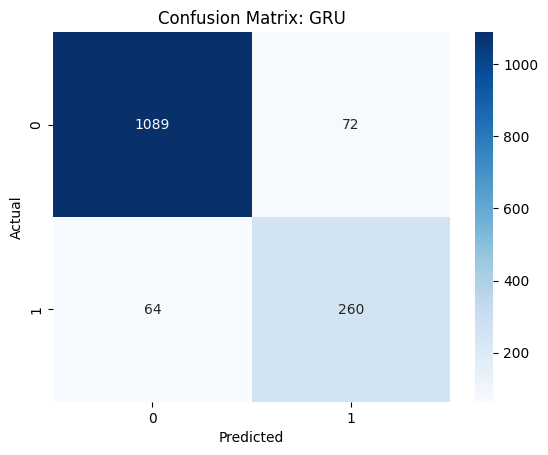

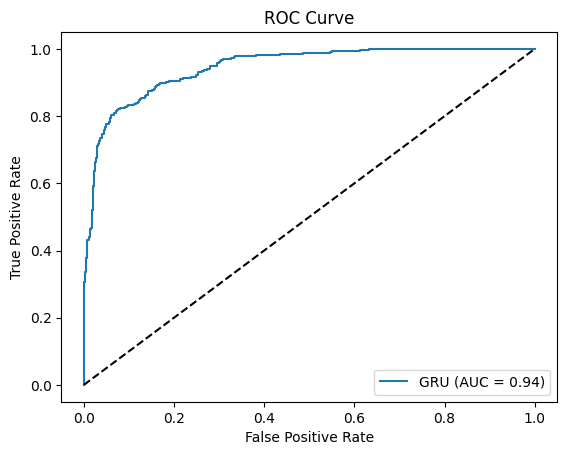

CNN Evaluation
Overall AUC: 0.9411
Onset Accuracy: 75.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      1161
         1.0       0.68      0.85      0.76       324

    accuracy                           0.88      1485
   macro avg       0.82      0.87      0.84      1485
weighted avg       0.90      0.88      0.89      1485


Regime Performance:
Bull Market Accuracy: 0.8882
Bull Market AUC: 0.8085
Bear Market Accuracy: 0.8465
Bear Market AUC: 0.6633


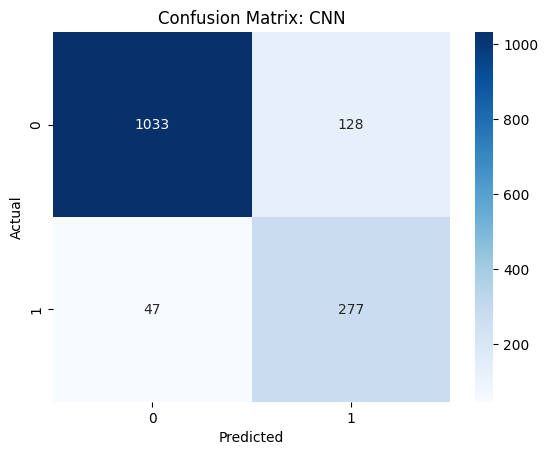

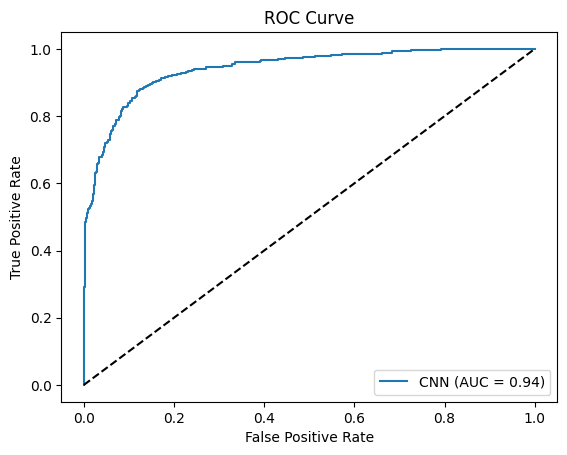

In [14]:
results['GRU']['best_params'] = {'hidden_dim': 64, 'lr': 0.001, 'dropout': 0.2, 'alpha': 0.5, 'gamma': 2.5}
results['CNN']['best_params'] = {'filters': 32, 'kernel': 4, 'lr': 0.01, 'dropout': 0.2, 'alpha': 0.75, 'gamma': 2.5}

for model_type, info in results.items():
    
    best_params = info['best_params']
    model_class = info['model_class']

    scaler = StandardScaler()
    X_dev_scaled = X_dev.copy()
    X_dev_scaled[feature_cols] = scaler.fit_transform(X_dev[feature_cols])
    X_test_scaled = X_test.copy()
    X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])

    dev_df = X_dev_scaled.assign(Target_Regime_5d=y_dev)
    test_df = X_test_scaled.assign(Target_Regime_5d=y_test)

    X_dev_seq, y_dev_seq, dev_indices = create_sequences(dev_df, feature_cols, SEQ_LENGTH)
    X_test_seq, y_test_seq, test_indices = create_sequences(test_df, feature_cols, SEQ_LENGTH)

    torch.manual_seed(42)
    if model_type == 'GRU':
        final_model = model_class(INPUT_DIM, best_params['hidden_dim'], 2, best_params['dropout']).to(DEVICE)
    else:
        final_model = model_class(INPUT_DIM, SEQ_LENGTH, best_params['dropout'], best_params['filters'], best_params['kernel']).to(DEVICE)

    final_model, _ = train_nn_model(
        final_model,
        (X_dev_seq, y_dev_seq), (X_test_seq, y_test_seq),
        dev_indices, test_indices,
        dev_df, test_df, 
        best_params['lr']
    )

    weights_path = f"weights/{model_type}_best_weights.pt"
    torch.save(final_model.state_dict(), weights_path)

    final_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test_seq).float().to(DEVICE)
        probs = torch.sigmoid(final_model(X_test_tensor).squeeze()).cpu().numpy()

    y_true_daily, y_probs_daily = aggregate_daily(test_df, test_indices, y_test_seq, probs)
    
    test_df_daily = df.loc[test_indices].drop_duplicates('Date').set_index('Date').sort_index()
    
    eval_results = evaluation.evaluate_model(model_type, y_true_daily, y_probs_daily, test_df_daily)
    
    evaluation.plot_confusion_matrix(eval_results['basic'], model_type)
    evaluation.plot_roc_curve(y_true_daily, y_probs_daily, model_type)

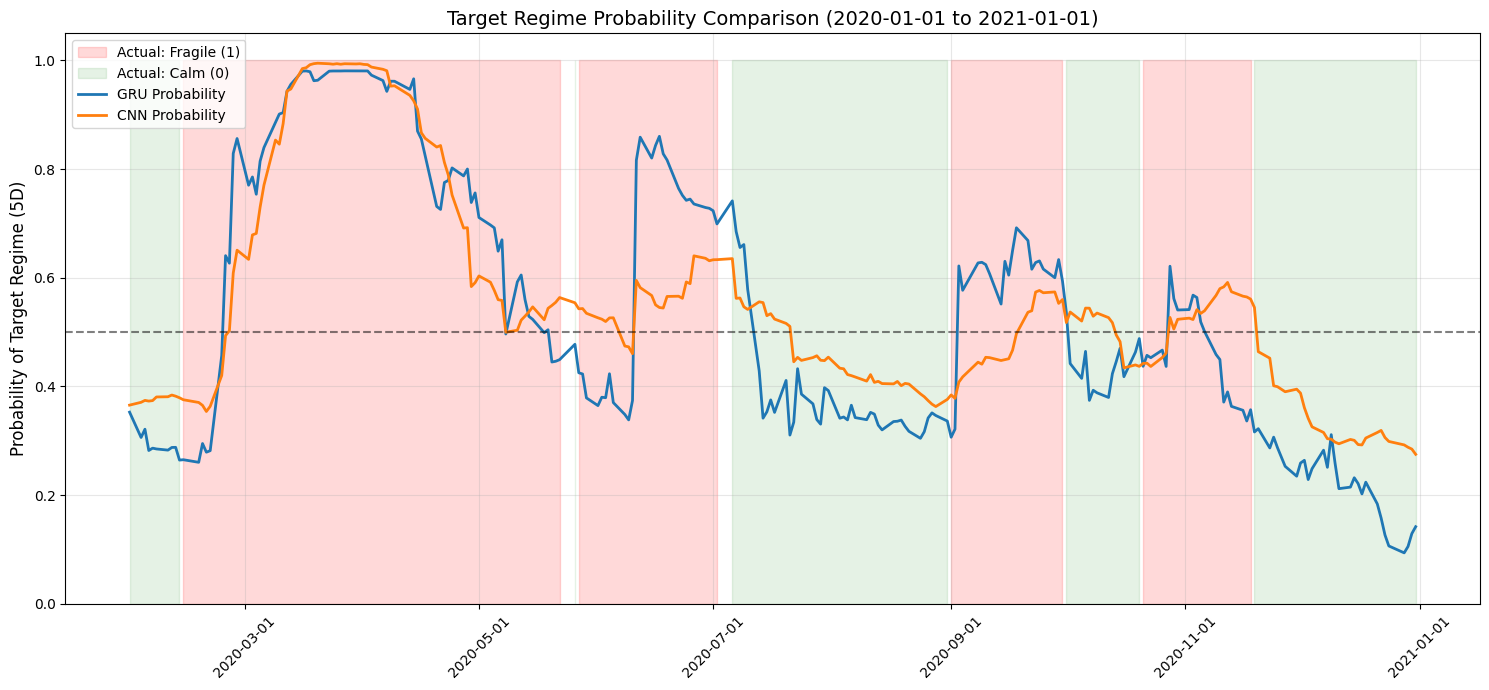

In [10]:
import src.evaluation as evaluation
import importlib

importlib.reload(evaluation)

comparison_probs = {}
y_true_daily_ref = None
daily_index_ref = test_df_daily.index.copy()

for model_type in ['GRU', 'CNN']:
    info = results[model_type]
    model_class = info['model_class']
    params = info['best_params']
    
    if model_type == 'GRU':
        model = model_class(INPUT_DIM, params['hidden_dim'], 2, params['dropout']).to(DEVICE)
    else:
        model = model_class(INPUT_DIM, SEQ_LENGTH, params['dropout'], params['filters'], params['kernel']).to(DEVICE)
    
    model.load_state_dict(torch.load(f"weights/{model_type}_best_weights.pt"))
    model.eval()
    
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test_seq).float().to(DEVICE)
        probs = torch.sigmoid(model(X_test_tensor).squeeze()).cpu().numpy()
    
    y_true_daily, y_probs_daily = aggregate_daily(test_df, test_indices, y_test_seq, probs)
    
    comparison_probs[model_type] = y_probs_daily
    y_true_daily_ref = y_true_daily 


evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2020-01-01', 
    end_date='2021-01-01'
)

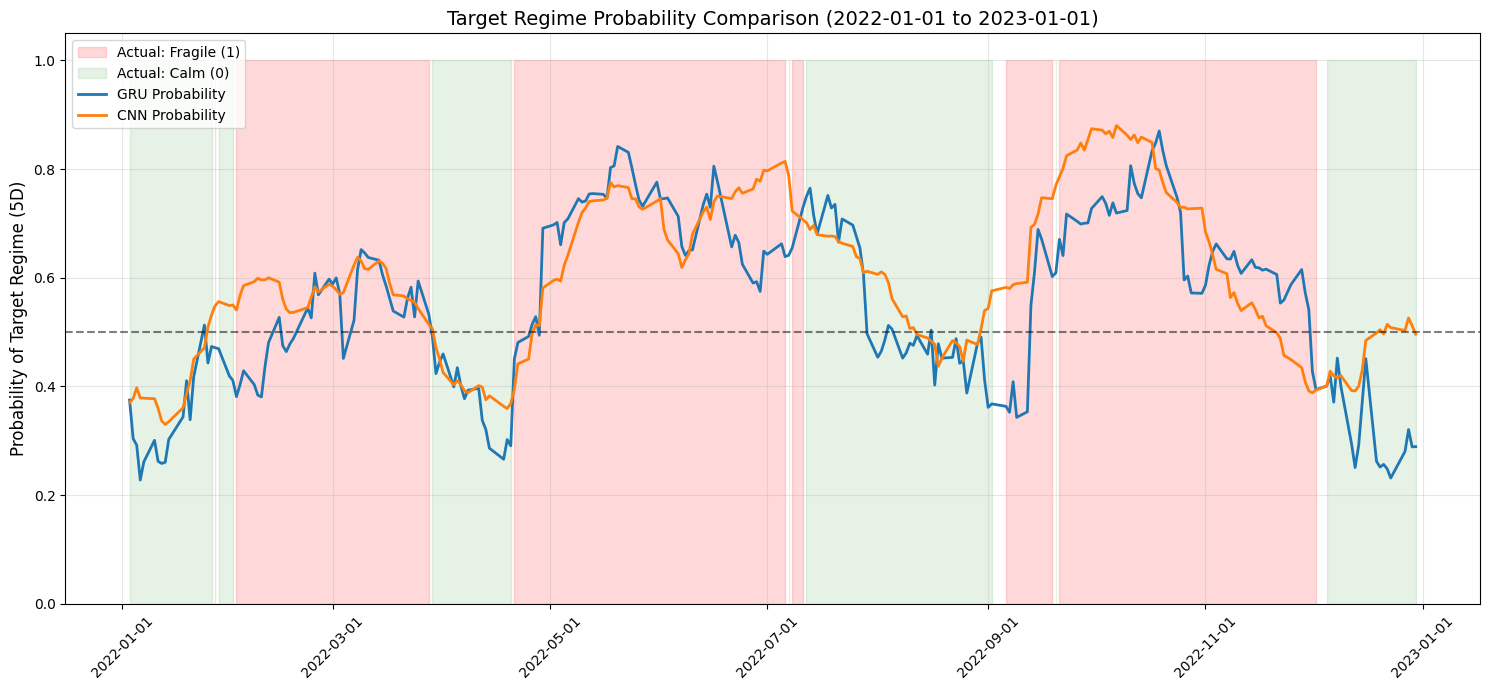

In [11]:
evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2022-01-01', 
    end_date='2023-01-01'
)

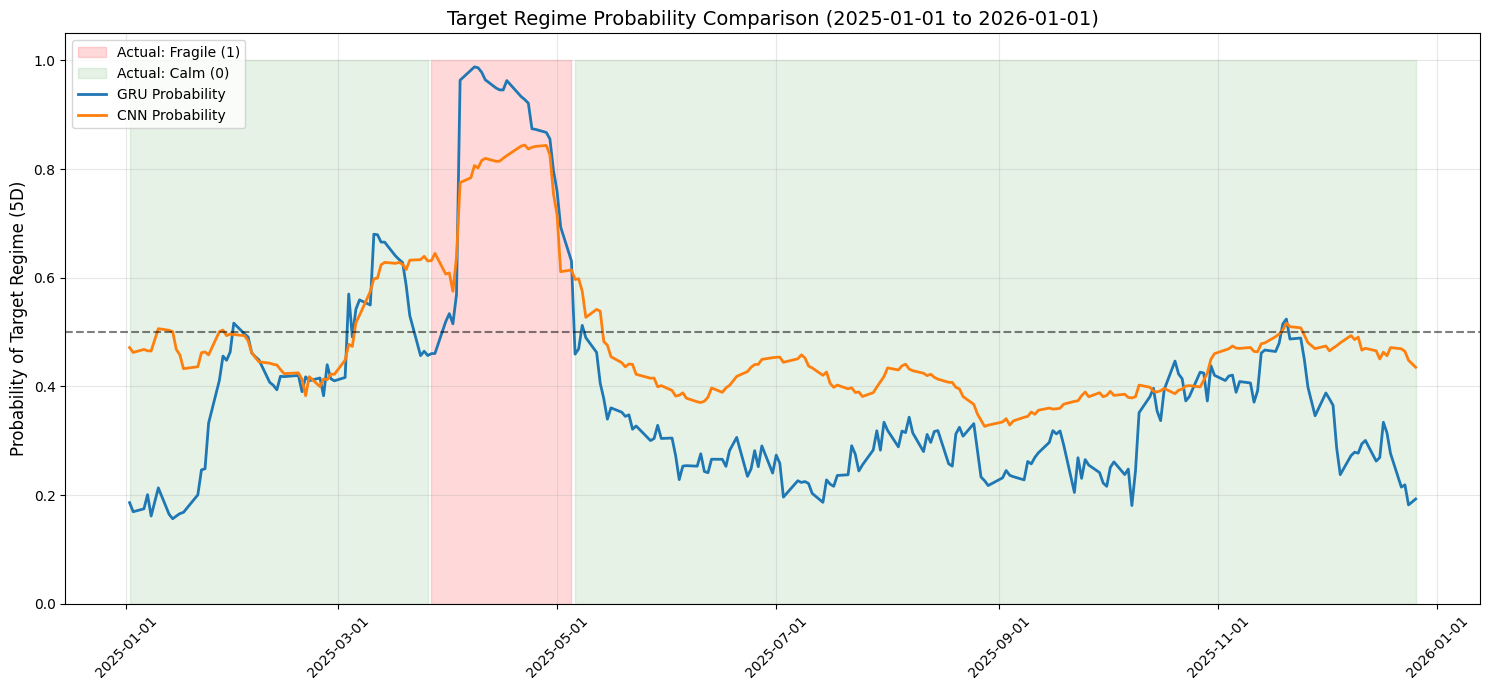

In [12]:
evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2025-01-01', 
    end_date='2026-01-01'
)